### Importing libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [54]:
df = pd.read_excel('relay-foods.xlsx')
df.head()

,OrderId,OrderDate,UserId,Unnamed: 3,CommonId,PupId,PickupDate
0,262,2009-01-11,47,NaN,TRQKD,2,2009-01-12
1,278,2009-01-20,47,NaN,4HH2S,3,2009-01-20
2,294,2009-02-03,47,NaN,3TRDC,2,2009-02-04
3,301,2009-02-06,47,NaN,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,NaN,FFYHD,2,2009-02-09


In [55]:
df=df.drop('Unnamed: 3',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderId     2891 non-null   int64         
 1   OrderDate   2891 non-null   datetime64[ns]
 2   UserId      2891 non-null   int64         
 3   CommonId    2891 non-null   object        
 4   PupId       2891 non-null   int64         
 5   PickupDate  2891 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 135.6+ KB


Creating a new column which consist of the month in which the order is made. This will help us make our cohort periods

In [56]:
df['Period'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,CommonId,PupId,PickupDate,Period
0,262,2009-01-11,47,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,FFYHD,2,2009-02-09,2009-02


In [57]:
df.info() #no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderId     2891 non-null   int64         
 1   OrderDate   2891 non-null   datetime64[ns]
 2   UserId      2891 non-null   int64         
 3   CommonId    2891 non-null   object        
 4   PupId       2891 non-null   int64         
 5   PickupDate  2891 non-null   datetime64[ns]
 6   Period      2891 non-null   object        
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 158.2+ KB


In [58]:
df['cohort'] = df.groupby('UserId')['OrderDate'] \
                 .transform('min') \
                 .apply(lambda x: x.strftime('%Y-%m'))     
df.set_index('UserId',inplace =True)
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,CommonId,PupId,PickupDate,Period,cohort
0,47,262,2009-01-11,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,FFYHD,2,2009-02-09,2009-02,2009-01


After finding the first month in which the order made by the user, we make our cohort columns(Above).

Now, we only work with relevant data as many variables are not of our need.So, we remove them after grouping by with cohort and period and keeping only the total users in tht period as feature.(Cohort on user retention,remember)


In [59]:
grouped = df.groupby(['cohort', 'Period'])
data = grouped.agg({'UserId': pd.Series.nunique})
data.rename(columns={'UserId': 'TotalUsers'}, inplace=True)
data.head()

TotalUsers
cohort  Period             
2009-01 2009-01          22
        2009-02           8
        2009-03          10
        2009-04           9
        2009-05          10

In [68]:
def cumulative_month(df):
    df['CumulativeMonth'] = np.arange(len(df)) + 1
    return df

data = data.groupby(level=0).apply(cumulative_month)
data.head()
#data['CumulativeMonth'].describe()"""

TotalUsers  CumulativeMonth
cohort  Period                              
2009-01 2009-01          22                1
        2009-02           8                2
        2009-03          10                3
        2009-04           9                4
        2009-05          10                5

In [69]:
data.reset_index(inplace=True)
data.set_index(['cohort', 'CumulativeMonth'], inplace=True)
data.head()
cohort_group_size = data['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

cohort
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

### Pivoting Using Pandas

In [71]:
user_retention = data['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention

cohort,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CumulativeMonth,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
ls=[x for x in user_retention.columns]
ls=ls[2:5]
ls

['2009-03', '2009-04', '2009-05']

### SNS Heatmap depicting user retention with time in %

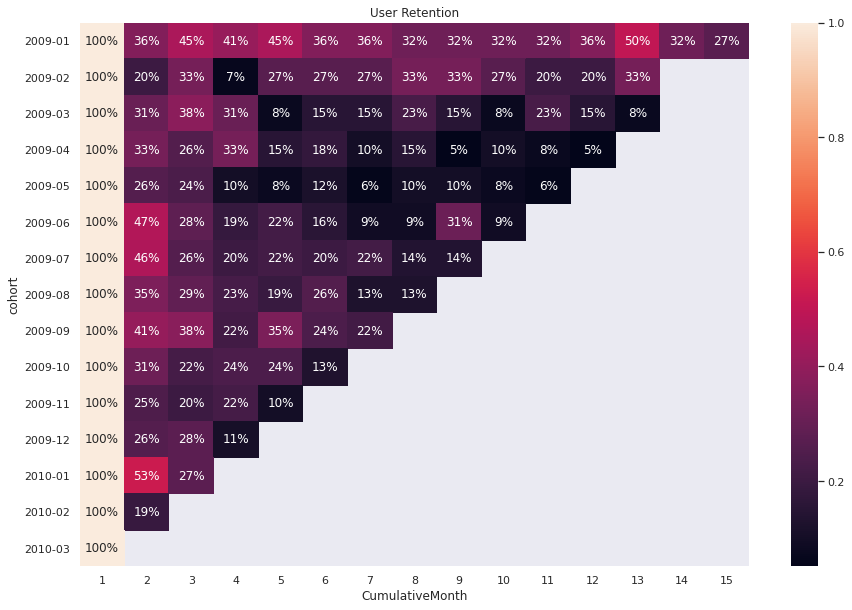

In [75]:
sns.set(style='dark')
plt.figure(figsize=(15,10))
plt.title('User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

### line graph for analysis

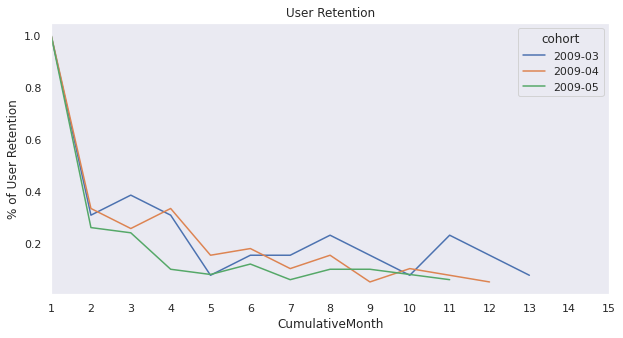

In [74]:
user_retention[ls].plot(figsize=(10,5))
plt.title('User Retention')
plt.xticks(np.arange(1, 15.1, 1))
plt.xlim(1, 15)
plt.ylabel('% of User Retention');